In [1]:
import itertools
import json
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
from CDPL import Chem
from fame3r.compute_descriptors import DescriptorGenerator, MoleculeProcessor
from rdkit.Chem import AllChem, PandasTools

In [2]:
PandasTools.RenderImagesInAllDataFrames(images=True)

## Rule and test datasets from GLORYx

In [3]:
testset = pd.DataFrame(
    json.loads(
        Path("./GLORYx/datasets/test_dataset/gloryx_test_dataset.json").read_text()
    )
).pipe(lambda df: df.assign(Molecule=df.smiles.map(AllChem.MolFromSmiles)))

In [4]:
rules = (
    pd.read_csv("./GLORYx/reaction_rules/gloryx_reactionrules.csv")
    .pipe(
        lambda df: df.assign(
            Reaction=df.SMIRKS.map(lambda smirks: AllChem.ReactionFromSmarts(smirks))
        )
    )
    .set_index(["Reaction name"])
)

rules.apply(lambda row: row.Reaction.SetProp("_Name", row.name), axis=1)

pass

In [5]:
rules["Name of rule subset"].value_counts()

Name of rule subset
Phase 1 SyGMa rules               151
CYP rules from GLORY (phase 1)     73
UGT rules (phase 2)                13
GST rules (phase 2)                 9
NAT rules (phase 2)                 5
Other phase 2 rules                 4
SULT rules (phase 2)                3
MT rules (phase 2)                  2
Name: count, dtype: int64

## Example molecule conversion

In [7]:
mol = AllChem.Mol(testset.loc[2, "Molecule"])

for atom in mol.GetAtoms():
    atom.SetIntProp("_Original", atom.GetIdx())

In [8]:
results = rules.Reaction.map(lambda rxn: rxn.RunReactants([mol])).pipe(
    lambda series: series[series != ()].map(np.concatenate)
)

results = np.concatenate(results.to_numpy())

In [9]:
prod = results[3]

In [10]:
retainedIdxs = [
    atom.GetIntProp("_Original")
    for atom in prod.GetAtoms()
    if atom.HasProp("_Original")
]

potentialSomIdxs = [
    atom.GetIdx() for atom in mol.GetAtoms() if atom.GetIdx() not in retainedIdxs
]

mol.__sssAtoms = potentialSomIdxs

for i, idx in enumerate(potentialSomIdxs):
    mol.GetAtomWithIdx(idx).SetAtomMapNum(i + 1)

mol_ = Chem.parseSMILES(AllChem.MolToSmiles(mol))
MoleculeProcessor.perceive_mol(mol_)

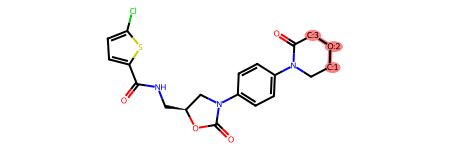

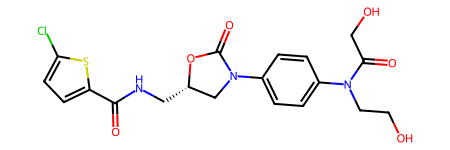

In [11]:
display(mol, prod)

## Example SOM probability prediction

In [12]:
famedg = DescriptorGenerator(radius=5)

In [13]:
fame3cf = joblib.load("./fame3r_data/model.joblib")

In [14]:
potential_soms = {
    atom.getProperty(Chem.AtomProperty.ATOM_MAPPING_ID): atom
    for atom in mol_.getAtoms()
    if atom.getProperty(Chem.AtomProperty.ATOM_MAPPING_ID)
}

In [15]:
fame3ds = [
    famedg.generate_descriptors(atom, mol_)[1] for atom in potential_soms.values()
]

In [16]:
fame3cf.predict_proba(fame3ds)[:, 1]

array([0.75, 0.06, 0.75])

## Potential library design #2

In [78]:
from pathlib import Path

import joblib
import numpy.typing as npt
from rdkit.Chem.rdmolops import GetDistanceMatrix

In [18]:
models = {
    path.name.removesuffix(".joblib"): joblib.load(path)
    for path in Path("models").glob("*.joblib")
}

In [170]:
subset_mappings = rules[~rules.index.duplicated()]["Name of rule subset"]

In [294]:
def get_strict_som_indices(reacted_mol: AllChem.Mol) -> list[int]:
    heavy_atoms = [atom for atom in reacted_mol.GetAtoms() if atom.GetAtomicNum() != 1]
    new_idx = [
        atom.GetIdx() for atom in heavy_atoms if not atom.HasProp("react_atom_idx")
    ]
    retained_idx = np.array(
        [atom.GetIdx() for atom in heavy_atoms if atom.HasProp("react_atom_idx")]
    )
    distances = GetDistanceMatrix(reacted_mol)[:, new_idx].min(axis=1)[retained_idx]
    minimum_indices = retained_idx[np.argwhere(distances == distances.min()).flatten()]

    return [int(idx) for idx in minimum_indices]

In [295]:
def to_concrete_reactions(
    reaction: AllChem.ChemicalReaction, educt: AllChem.Mol
) -> AllChem.ChemicalReaction:
    products = itertools.chain.from_iterable(reaction.RunReactants([educt]))
    # TODO: fix what happens when reaction matches multiple times!
    products = {AllChem.MolToInchi(mol): mol for mol in products}.values()

    reactions = []
    for product in products:
        AllChem.SanitizeMol(product)
        product = AllChem.AddHs(product)
        educt_ = AllChem.Mol(educt)

        for i, product_idx in enumerate(get_strict_som_indices(product)):
            product_atom = product.GetAtomWithIdx(product_idx)
            product_atom.SetAtomMapNum(i + 1)
            educt_.GetAtomWithIdx(
                product_atom.GetIntProp("react_atom_idx")
            ).SetAtomMapNum(i + 1)

        # for atom in product.GetAtoms():
        #     if not atom.HasProp("old_mapno") or atom.GetAtomicNum() == 1:
        #         continue
        #
        #     mapno = atom.GetIntProp("old_mapno")
        #     educt_.GetAtomWithIdx(atom.GetIntProp("react_atom_idx")).SetAtomMapNum(
        #         mapno
        #     )
        #     product.GetAtomWithIdx(atom.GetIdx()).SetAtomMapNum(mapno)

        concrete_reaction = AllChem.ChemicalReaction()
        concrete_reaction.AddReactantTemplate(educt_)
        concrete_reaction.AddProductTemplate(product)
        if reaction.HasProp("_Name"):
            concrete_reaction.SetProp("_Name", reaction.GetProp("_Name"))

        reactions.append(concrete_reaction)

    return reactions

In [296]:
def educt_som_descriptors(marked_smiles: str) -> npt.NDArray[np.float64]:
    cdpkit_marked_educt = Chem.parseSMILES(marked_smiles)
    MoleculeProcessor.perceive_mol(cdpkit_marked_educt)

    som_atoms_unordered = {
        atom.getProperty(Chem.AtomProperty.ATOM_MAPPING_ID): atom
        for atom in cdpkit_marked_educt.getAtoms()
        if atom.getProperty(Chem.AtomProperty.ATOM_MAPPING_ID)
    }

    descriptors = [
        famedg.generate_descriptors(som_atoms_unordered[i], cdpkit_marked_educt)[1]
        for i in sorted(som_atoms_unordered.keys())
        if i in som_atoms_unordered  # TODO: make this create an all-nan entry instead
    ]

    return np.asarray(descriptors, dtype=np.float64)

In [297]:
def reactions_to_table(reactions: list[AllChem.ChemicalReaction]) -> pd.DataFrame:
    return pd.DataFrame(
        [
            {
                "Educt": rxn.GetReactants()[0],
                "Product": rxn.GetProducts()[0],
                "Reaction": rxn.GetProp("_Name") if rxn.HasProp("_Name") else None,
            }
            for rxn in reactions
        ]
    )

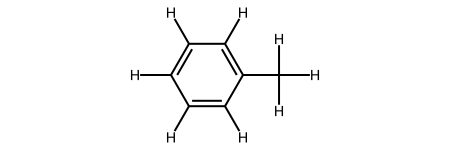

In [298]:
mol = AllChem.MolFromSmiles("c1ccccc1C")
mol = AllChem.AddHs(mol)
mol

In [299]:
reactions = list(
    itertools.chain.from_iterable(
        [to_concrete_reactions(reaction, mol) for reaction in rules.Reaction]
    )
)

,Educt,Product,Reaction,Source,Probabilities,P_max
2,,,carboxylation_(benzylic_CH3),Phase 1 SyGMa rules,[0.39],0.39
3,,,benzylic_hydroxylation_(c-CH3),Phase 1 SyGMa rules,[0.39],0.39
5,,,aliphatic hydroxylation,CYP rules from GLORY (phase 1),[0.39],0.39
0,,,aromatic_hydroxylation_(para_to_carbon),Phase 1 SyGMa rules,[0.24],0.24
4,,,aromatic_oxidation,Phase 1 SyGMa rules,"[0.19, 0.24]",0.24
8,,,aromatic hydroxylation,CYP rules from GLORY (phase 1),[0.24],0.24
1,,,aromatic_hydroxylation_(meta_to_carbon),Phase 1 SyGMa rules,[0.19],0.19
7,,,aromatic hydroxylation,CYP rules from GLORY (phase 1),[0.19],0.19
6,,,aromatic hydroxylation,CYP rules from GLORY (phase 1),[0.1],0.10

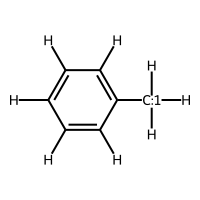
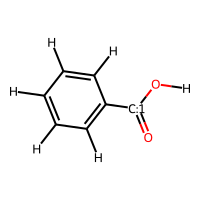
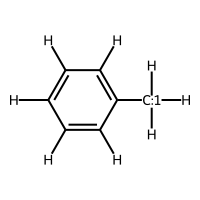
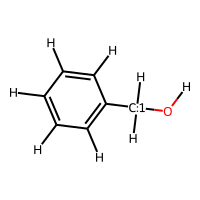
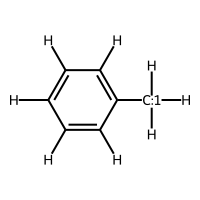
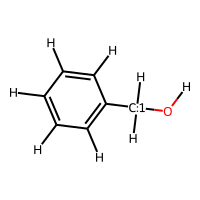
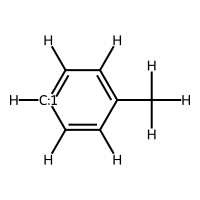
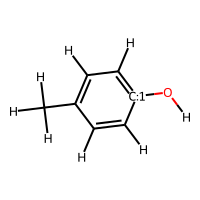
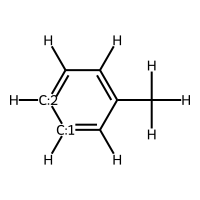
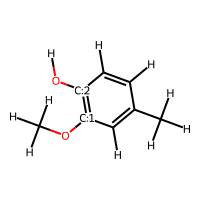
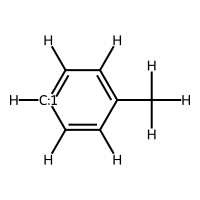
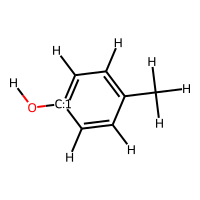
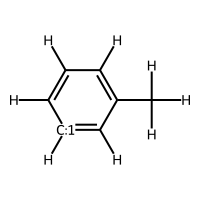
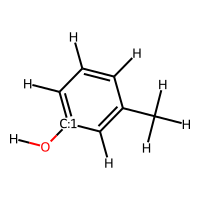
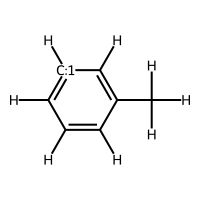
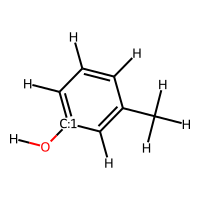
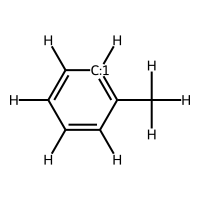
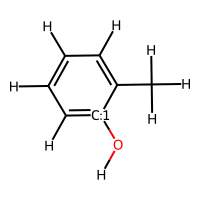

In [302]:
reactions_to_table(reactions).pipe(
    lambda df: df.assign(
        Source=df.Reaction.map(lambda name: subset_mappings[name]),
        Descriptors=df.Educt.map(
            lambda mol: educt_som_descriptors(AllChem.MolToSmiles(mol))
        ),
    )
).pipe(
    lambda df: df.assign(
        Probabilities=df.apply(
            lambda row: models[row.Source].predict_proba(row.Descriptors)[:, -1], axis=1
        )
    )
).pipe(lambda df: df.assign(P_max=df.Probabilities.map(max)))[
    ["Educt", "Product", "Reaction", "Source", "Probabilities", "P_max"]
].sort_values(["P_max"], ascending=False)